# Notebook for NSREC publication plots
A collections of analyses and plots for our NSREC paper. As multiple data sets are imported, I am adding caching of parsed data in for of pickle files to save some time. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from src.data_interface import DataInterface
from src.analysis.base_tools import BaseTools
from src.analysis.ibex_coremark_tools import IbexCoremarkTools
from src.analysis.ibex_hwsec_coremark_tools import IbexHwsecCoremarkTools
from src.run_info.run_info import RunInfo
from typing import List, Tuple, NamedTuple
from src.analysis.structures.seu_log import SeuLog
from src.analysis.structures.node import Node

import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.special import comb
from anytree.exporter import DotExporter

def visualization_setup():
    # Interactive plots. Requires tkinter on the machine running the code
    mpl.use("TkAgg")
    # Latex formatting for plots. Some visualizations might not work without this
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["mathtext.fontset"] = "dejavuserif"

## Parse data sets
* Only run this if data has changed. Takes a loooong time
* If re-parsing within a notebook, its recommended to restart the kernel

In [2]:
""" 
Declare which data sets you want to parse in a dict, so they can be looped thru.
 
The key is the name of the data set, the value is a list with the run_info file and 
a boolean indicating if the raw data is to be parsed and cached. 
"""

data_set_info = {
    "baseline"          : ["src/run_info/ibex_coremark.ini", 0],  
    "RV32MSingleCycle"  : ["src/run_info/ibex_RV32MSingleCycle_coremark.ini", 0],
    "regfileTMR"  : ["src/run_info/ibex_regfileTMR.ini", 0],
    "compOptO1"  : ["src/run_info/ibex_compOptO1.ini", 0]
}

In [3]:
class SeuDataSet(NamedTuple):
    runinfo: RunInfo
    root: Node
    node: Tuple[Node]
    root_data: SeuLog
    node_data: SeuLog
    golden: pd.Series
    data_interface: DataInterface

for data_set, runinfo_path in data_set_info.items():
    if runinfo_path[1]: 
        runinfo = RunInfo(runinfo_path[0])
        data_interface = DataInterface(runinfo)
        golden = data_interface.golden_log
        node = data_interface.get_node_by_name("register_file_i")[0]
        root = data_interface.root
        node_data = data_interface.get_seu_log_by_node(node)
        root_data = data_interface.get_seu_log_by_node(root)
        node_runs = list(node_data.index)

        save = SeuDataSet(runinfo, root, node, root_data, node_data, golden, data_interface)
        
        try:
            pickle.dump(save, open(f"cache/{data_set}.pickle", "wb"))
            print(f"Saved {data_set}.pickle to cache.")
        except Exception as e:
            print(e)
            print(f"Could not save {data_set}.pickle to cache.")


## Load Cached Data

In [4]:
# load data sets from cache
data_sets = {name : pickle.load(open(f"cache/{name}.pickle", "rb")) for name in data_set_info.keys()}
# print(data_sets)

## Analyses

In [5]:

import matplotlib.pyplot as plt

plt.rcParams.update({
    # 'font.family': 'serif',
    # 'font.serif': ['Times', 'Palatino', 'New Century Schoolbook', 'Bookman', 'Computer Modern Roman'],
    'font.size': 8,
    'axes.labelsize': 8,
    'axes.titlesize': 8,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 6,
    'figure.dpi': 300,
    'figure.figsize': [3.39, 2.10],
    'lines.linewidth': 0.5,
    'lines.markersize': 0.5,
    'lines.markeredgewidth': 0.5,
    # 'text.usetex': True,
    # 'text.latex.preamble': r'\usepackage{amsmath}'
})

# _ = BaseTools.error_classification_confidence(data_interface, data_sets["RV32MSingleCycle"].root, visualize=True)
# _ = BaseTools.error_classification_confidence(data_interface, data_sets["RV32MSingleCycle"].node, visualize=True)

### Grouped bar plots

Group by config

compot cycles: 593955

Raw Counts:
      baseline  RV32MSingleCycle  regfileTMR  compOptO1
NE       87901             84481       48363      30063
SDC       7382              7028         348       2923
SEFI      3151              3078         457       1387

Proportional:
      baseline  RV32MSingleCycle  regfileTMR  compOptO1
NE    0.892994          0.893157    0.983628   0.874611
SDC   0.074994          0.074302    0.007078   0.085038
SEFI  0.032011          0.032541    0.009295   0.040351

e_extrapolated:
                       SDC      SEFI
baseline          0.074994  0.032011
RV32MSingleCycle  0.071179  0.031174
regfileTMR        0.012243  0.016078
compOptO1         0.105463  0.050043
\nComparison $r$:
                       SDC      SEFI
baseline          1.000000  1.000000
RV32MSingleCycle  1.053600  1.026864
regfileTMR        6.125249  1.990954
compOptO1         0.711100  0.639672

Conf. Intervals:
                       SDC      SEFI
baseline          0.003291  0.002199
RV32M

/tmp/ipykernel_25256/4125324867.py:66: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_r = e_extrapolated.div(e_extrapolated.iloc[0,:]).applymap(lambda x: 1/x)


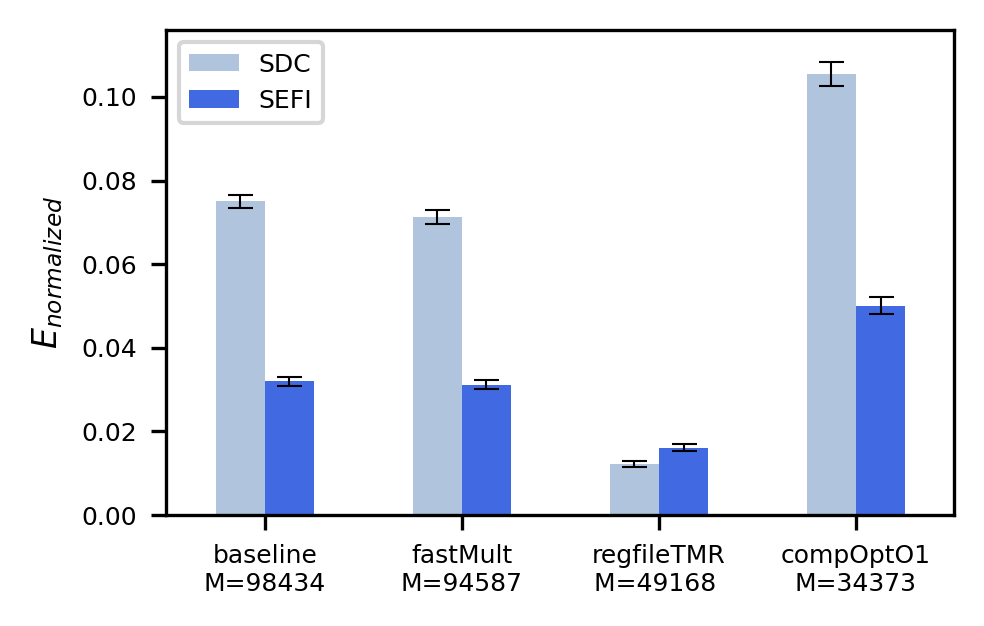

In [6]:
from src.analysis.structures.error_definitions import (
    SilentError,
    DataCorruptionError,
    CriticalError,
    BaseError,
)

x_tick_locs = np.arange(len(data_sets.keys()))


# provide which errors are to be plotted
errors_classes_to_plot = [DataCorruptionError, CriticalError]
transpose = 1
normalize = 1 # normalize results to baseline injection population size

df_raw = pd.DataFrame()
df_conf = pd.DataFrame()
df_std = pd.DataFrame()
df_r = pd.DataFrame()

# Multi bar plot grouped by configuration
for name, data_set in data_sets.items():

    # get error outcomes
    data = BaseTools.error_classification(data_set.data_interface, data_set.root, visualize=False)
    data_conf, data_std = BaseTools.error_classification_confidence(data_set.data_interface, data_set.root, visualize=False)
    data_conf = data_conf.rename(name)
    data_std = data_std.rename(name)
    # count unique values
    counts = data.value_counts()
    counts = counts.rename(name)

    # build data to plot
    df_raw = pd.concat([df_raw, counts], axis=1, sort=False)
    df_conf = pd.concat([df_conf, data_conf], axis=1, sort=False)
    df_std = pd.concat([df_std, data_std], axis=1, sort=False)

# get proportions of each error class against sum of each row
# i.e. f_samples / n_samples
N_sampled = df_raw.sum(axis=0)
df_prop = df_raw.div(N_sampled, axis=1) # proportional

print("compot cycles:", getattr(data_sets["compOptO1"].runinfo.data, "cpu_cyles"))

# population size of each config normalized to baseline population

S_pop = np.array([getattr(data_sets[name].runinfo.data, "cpu_cyles") * getattr(data_sets[name].runinfo.data, "vpi_bits") for name in data_sets.keys()]) / (getattr(data_sets["baseline"].runinfo.data, "cpu_cyles")*getattr(data_sets["baseline"].runinfo.data, "vpi_bits"))
s_hard_list = np.array([getattr(data_sets[name].runinfo.data, "cpu_cyles") * getattr(data_sets[name].runinfo.data, "vpi_bits") for name in data_sets.keys()])


# calc extrapolated f = S * (f_samples / M_samples)
if normalize:
    e_extrapolated = df_prop.multiply(S_pop, axis=1)
else: 
    e_extrapolated = df_prop

# plot
error_class_names = [str(error_class.name) for error_class in errors_classes_to_plot]
e_extrapolated = e_extrapolated.loc[error_class_names]
df_conf = df_conf.loc[error_class_names]
df_std = df_std.loc[error_class_names]

if transpose:
    e_extrapolated = e_extrapolated.transpose()
    # calc improvement ratio df_r: (e_extrapolated / baselnine) ^ -1
    df_r = e_extrapolated.div(e_extrapolated.iloc[0,:]).applymap(lambda x: 1/x) 
    df_conf = df_conf.transpose()
    df_std = df_std.transpose()

print("\nRaw Counts:")
print(df_raw)

print("\nProportional:")
print(df_prop)

print("\ne_extrapolated:")
print(e_extrapolated)

print(r"\nComparison $r$:")
print(df_r)

print("\nConf. Intervals:")
print(df_conf)

print("\nStd dev.:")
print(df_std)

ax = e_extrapolated.plot.bar(
    color=[error_class.color for error_class in errors_classes_to_plot], 
    yerr=df_conf/2, 
    capsize=3,
    rot=0
)

legend = ax.get_legend_handles_labels()

if transpose: 
    ax.set_xticklabels([f"baseline\nM={N_sampled.iloc[0]:.0f}", f"fastMult\nM={N_sampled.iloc[1]:.0f}",f"regfileTMR\nM={N_sampled.iloc[2]:.0f} ", f"compOptO1\nM={N_sampled.iloc[3]:.0f}"], rotation=0)
    ax.set_ylim(0, 1.1 * e_extrapolated.max().max())
    if normalize:
        ax.set_ylabel(r"$E_{normalized}$")
    else:
        ax.set_ylabel(r"Proportional Error $E$")

fig = ax.get_figure()
fig.savefig(f"plots/multi_bar_four_configs", bbox_inches="tight")
    # ax = df_r.plot.bar(
    #     color=[error_class.color for error_class in errors_classes_to_plot], 
    #     yerr=df_conf/2, 
    #     capsize=3,
    #     rot=0
    # )
    # for container in ax.containers:
    #     ax.bar_label(container,padding=3)
    # for i, name in enumerate(name_list):
    #     text = f"$\sigma={{{std[name]:.1e}}}$\n"
    #     text += f"CI size: {2*ci[name]:.1e}\n"
    #     ax.text(i - 0.2, text_height, text, color="black")



Raw Counts:
      baseline  RV32MSingleCycle  regfileTMR  compOptO1
NE       27024             25857     31295.0       8268
SDC       6033              5645         NaN       2584
SEFI       720               711         NaN        757

Proportional:
      baseline  RV32MSingleCycle  regfileTMR  compOptO1
NE    0.800071          0.802688         1.0   0.712206
SDC   0.178613          0.175240         NaN   0.222586
SEFI  0.021316          0.022072         NaN   0.065208

e_extrapolated:
                       SDC      SEFI
baseline          0.178613  0.021316
RV32MSingleCycle  0.167875  0.021144
regfileTMR             NaN       NaN
compOptO1         0.276048  0.080870
\nComparison $r$:
                       SDC      SEFI
baseline          1.000000  1.000000
RV32MSingleCycle  1.063963  1.008138
regfileTMR             NaN       NaN
compOptO1         0.647035  0.263587

Conf. Intervals:
                       SDC      SEFI
baseline          0.008170  0.003081
RV32MSingleCycle  0.008303 

/tmp/ipykernel_25256/230472864.py:57: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_r = e_extrapolated.div(e_extrapolated.iloc[0,:]).applymap(lambda x: 1/x)


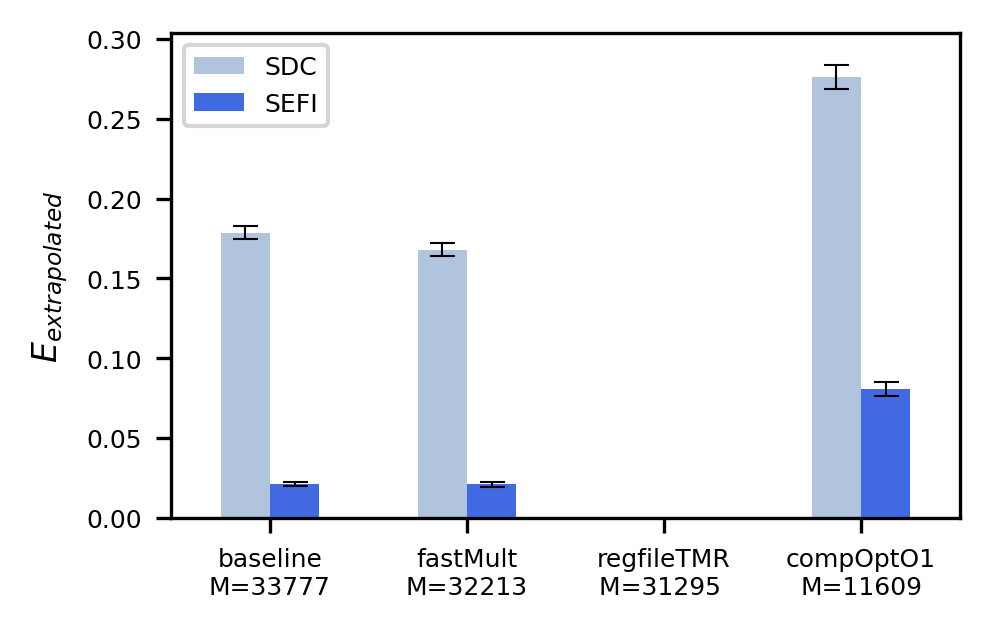

In [7]:

from src.analysis.structures.error_definitions import (
    SilentError,
    DataCorruptionError,
    CriticalError,
    BaseError,
)

x_tick_locs = np.arange(len(data_sets.keys()))


# provide which errors are to be plotted
errors_classes_to_plot = [DataCorruptionError, CriticalError]
transpose = 1

df_raw = pd.DataFrame()
df_conf = pd.DataFrame()
df_std = pd.DataFrame()
df_r = pd.DataFrame()

# Multi bar plot grouped by configuration
for name, data_set in data_sets.items():

    # get error outcomes
    data = BaseTools.error_classification(data_set.data_interface, data_set.node, visualize=False)
    data_conf, data_std = BaseTools.error_classification_confidence(data_set.data_interface, data_set.node, visualize=False)
    data_conf = data_conf.rename(name)
    data_std = data_std.rename(name)
    # count unique values
    counts = data.value_counts()
    counts = counts.rename(name)

    # build data to plot
    df_raw = pd.concat([df_raw, counts], axis=1, sort=False)
    df_conf = pd.concat([df_conf, data_conf], axis=1, sort=False)
    df_std = pd.concat([df_std, data_std], axis=1, sort=False)

# get proportions of each error class against sum of each row
# i.e. f_samples / n_samples
N_sampled = df_raw.sum(axis=0)
df_prop = df_raw.div(N_sampled, axis=1) # proportional

# population size of each config normalized to baseline, is missing VPI?
S_pop = np.array([getattr(data_sets[name].runinfo.data, "cpu_cyles") for name in data_sets.keys()]) / getattr(data_sets["baseline"].runinfo.data, "cpu_cyles")

# calc extrapolated f = S * (f_samples / M_samples)
e_extrapolated = df_prop.multiply(S_pop, axis=1)

# plot
error_class_names = [str(error_class.name) for error_class in errors_classes_to_plot]
e_extrapolated = e_extrapolated.loc[error_class_names]
df_conf = df_conf.loc[error_class_names]
df_std = df_std.loc[error_class_names]

if transpose:
    e_extrapolated = e_extrapolated.transpose()
    # calc improvement ratio df_r: (e_extrapolated / baselnine) ^ -1
    df_r = e_extrapolated.div(e_extrapolated.iloc[0,:]).applymap(lambda x: 1/x) 
    df_conf = df_conf.transpose()
    df_std = df_std.transpose()

print("\nRaw Counts:")
print(df_raw)

print("\nProportional:")
print(df_prop)

print("\ne_extrapolated:")
print(e_extrapolated)

print(r"\nComparison $r$:")
print(df_r)

print("\nConf. Intervals:")
print(df_conf)

print("\nStd dev.:")
print(df_std)

ax = e_extrapolated.plot.bar(
    color=[error_class.color for error_class in errors_classes_to_plot], 
    yerr=df_conf/2, 
    capsize=3,
    rot=0
)

legend = ax.get_legend_handles_labels()

if transpose: 

    ax.set_xticklabels([f"baseline\nM={N_sampled.iloc[0]:.0f}", f"fastMult\nM={N_sampled.iloc[1]:.0f}",f"regfileTMR\nM={N_sampled.iloc[2]:.0f} ", f"compOptO1\nM={N_sampled.iloc[3]:.0f}"], rotation=0)

    ax.set_ylim(0, 1.1 * e_extrapolated.max().max())
    ax.set_ylabel(r"$E_{extrapolated}$")

    # ax = df_r.plot.bar(
    #     color=[error_class.color for error_class in errors_classes_to_plot], 
    #     yerr=df_conf/2, 
    #     capsize=3,
    #     rot=0
    # )
    # for container in ax.containers:
    #     ax.bar_label(container,padding=3)
    # for i, name in enumerate(name_list):
    #     text = f"$\sigma={{{std[name]:.1e}}}$\n"
    #     text += f"CI size: {2*ci[name]:.1e}\n"
    #     ax.text(i - 0.2, text_height, text, color="black")


/home/anvesh/projects/Ibex-Analysis/src/analysis/ibex_coremark_tools.py:79: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


TypeError: 'int' object is not callable

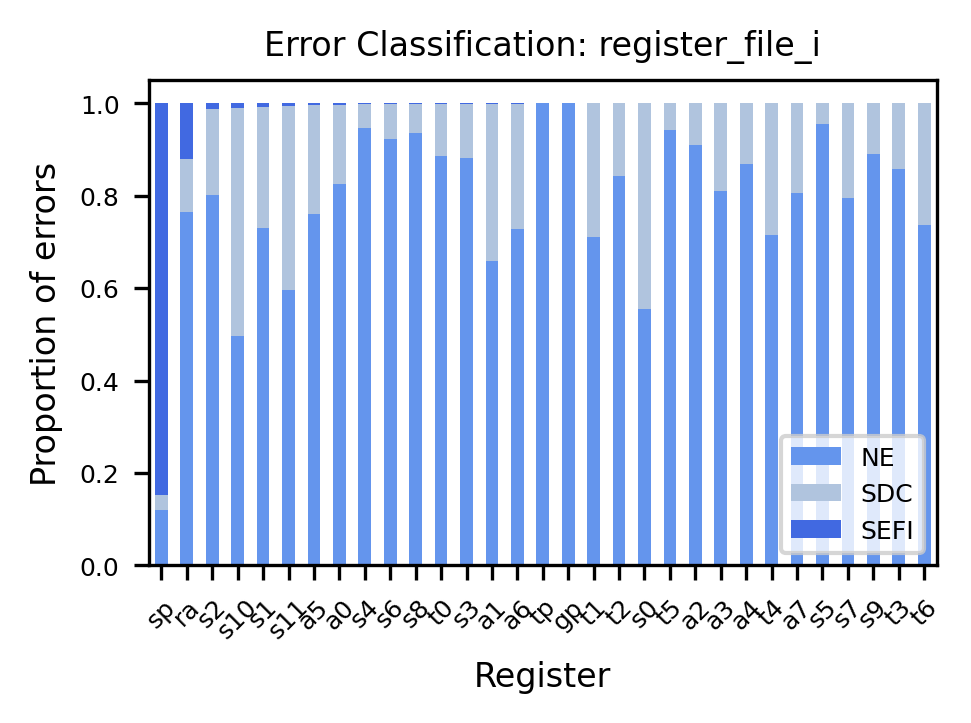

In [12]:
df_regs, fig = IbexCoremarkTools.stacked_register_error_class(
    data_sets["baseline"].data_interface, data_sets["baseline"].node, visualize=True, filter=1
)

baseline_len = len(data_sets["baseline"].node_data)
fig.axes[0].tick_params(axis="x", labelsize=7)
fig.axes[0].set_title("")
fig.axes[0].set_xlabel("Register Name")
fig.savefig(f"plots/stacked_register_error_class_baseline_N{baseline_len}.png", bbox_inches="tight")

df_regs, fig = IbexCoremarkTools.stacked_register_error_class(
    data_sets["compOptO1"].data_interface, data_sets["compOptO1"].node, visualize=True, filter=1
)

len = len(data_sets["compOptO1"].node_data)
fig.axes[0].tick_params(axis="x", labelsize=7)
fig.axes[0].set_title("")
fig.axes[0].set_xlabel("Register Name")
fig.savefig(f"plots/stacked_register_error_class_compOptO1_N{len}.png", bbox_inches="tight")

/home/anvesh/projects/Ibex-Analysis/src/analysis/base_tools.py:217: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Text(1500000.0, 0.25, 'baseline $M=34k$')

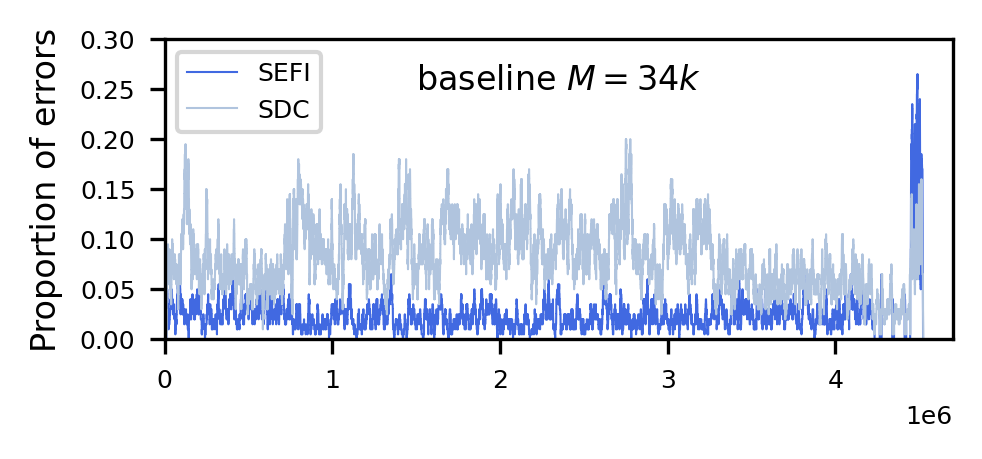

In [ ]:
# _, fig = IbexCoremarkTools.stacked_register_error_class(
#     data_sets["RV32MSingleCycle"].data_interface, data_sets["RV32MSingleCycle"].node, visualize=True
# )

plt.rcParams.update({
    # 'font.family': 'serif',
    # 'font.serif': ['Times', 'Palatino', 'New Century Schoolbook', 'Bookman', 'Computer Modern Roman'],
    'font.size': 8,
    'axes.labelsize': 8,
    'axes.titlesize': 8,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 6,
    'figure.dpi': 300,
    'figure.figsize': [3.39, 1.30],
    'lines.linewidth': 0.5,
    'lines.markersize': 0.5,
    'lines.markeredgewidth': 0.5,
    # 'text.usetex': True,
    # 'text.latex.preamble': r'\usepackage{amsmath}'
})
x = BaseTools.windowed_error_rate(
    data_sets["baseline"].data_interface, data_sets["baseline"].root, "injection_cycle", 
    visualize=True, window_size=200
)


fig2 = x[-1]
fig2.axes[0].set_ylim(0, 0.3)
fig2.axes[0].set_xlim(0,4.7e6)
fig2.axes[0].legend()
fig2.axes[0].set_ylabel("Proportion of errors")
fig2.axes[0].text(1.5e6, 0.25, r'baseline', fontsize=8, color="black")
fig2.savefig(f"plots/windowed_error_baseline.png", bbox_inches="tight")

In [34]:

x = BaseTools.windowed_error_rate(
    data_sets["compOptO1"].data_interface, data_sets["compOptO1"].root, "injection_cycle", 
    visualize=True, window_size=200
)

fig2 = x[-1]
fig2.axes[0].set_ylim(0, 0.3)
fig2.axes[0].set_xlim(0, 6e6)
fig2.axes[0].legend()
fig2.axes[0].set_xlabel("Execution Time [ns]")
fig2.axes[0].set_ylabel("Proportion of errors")
fig2.axes[0].text(1.8e6, 0.25, r'compOptO1', fontsize=8, color="black")
fig2.savefig(f"plots/windowed_error_compopt1.png", bbox_inches="tight")

In [26]:
fig = x[-1]
fig.axes[0].set_title("")
fig.axes[0].set_xlabel("Register Name")
fig.show()
fig2.axes[0].text(3e6, 0.25, r'\texttt{compOptO1}, M=34k', fontsize=8, color="black")

/tmp/ipykernel_25256/295089075.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Text(3000000.0, 0.25, '\\texttt{compOptO1}, M=34k')